In [1]:
!pip install pymongo

In [2]:
import os
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from bson import json_util
from scipy.stats import linregress

In [3]:
def read_data_from_file(file_path):
  # Read raw file content
  with open(file_path, 'r') as file:
      content = file.read()

  # Replace MongoDB-specific data types with JSON-compatible ones
  content = re.sub(r'ObjectId\("([^"]+)"\)', r'{"$oid": "\1"}', content)
  content = re.sub(r'ISODate\("([^"]+)"\)', r'{"$date": "\1"}', content)
  content = re.sub(r'NumberInt\((\d+)\)', r'\1', content)

  # Parse JSON using bson.json_util
  data = json_util.loads(content)

  # Return audio comparisons from data
  return data['audioComparisons']

In [4]:
def extract_audio_comparisons_data(audio_comparisons):
  # Initialize vectors with 15 positions, all set to 0
  interpolation_frequencies = [0] * 15
  range_frequencies = [0] * 15
  range_play_frequencies_1 = [0] * 15
  range_play_frequencies_2 = [0] * 15
  different_responses_count = [0] * 15

  for comparison in audio_comparisons:
    audioFile1 = comparison['audioFile1']
    audioFile2 = comparison['audioFile2']

    playCountFile1 = comparison['playCountFile1']
    playCountFile2 = comparison['playCountFile2']

    isSame = comparison['isSame']

    # Extract numbers using regex
    value1 = int(re.search(r'_(\d+)$', audioFile1).group(1))
    value2 = int(re.search(r'_(\d+)$', audioFile2).group(1))

    # Increment the corresponding position in the vectors
    interpolation_frequencies[value1 - 1] += 1
    interpolation_frequencies[value2 - 1] += 1
    range_frequencies[abs(value1 - value2)] += 1
    range_play_frequencies_1[abs(value1 - value2)] += playCountFile1
    range_play_frequencies_2[abs(value1 - value2)] += playCountFile2
    different_responses_count[abs(value1 - value2)] += 1 if not isSame else 0

  average_range_play_frequencies_1 = np.divide(range_play_frequencies_1, range_frequencies)
  average_range_play_frequencies_2 = np.divide(range_play_frequencies_2, range_frequencies)
  different_responses_proportion = np.divide(different_responses_count, range_frequencies)

  return interpolation_frequencies, range_frequencies, average_range_play_frequencies_1, average_range_play_frequencies_2, different_responses_proportion

In [5]:
def plot_frequency_histograms(interpolation_frequencies, range_frequencies, average_range_play_frequencies_1, average_range_play_frequencies_2):
  # Create figure and gridspec
  plt.figure(figsize=(15, 8))
  gs = plt.GridSpec(2, 2)

  # Plot 1: Interpolation frequencies histogram
  ax1 = plt.subplot(gs[0, 0])  # First row, first column
  ax1.bar(range(1, 16), interpolation_frequencies, color='royalblue')
  ax1.set_title("Number of occurrences of each interpolated sample")
  ax1.set_xlabel("Number of the interpolated sample")
  ax1.set_ylabel("Occurrences")
  ax1.set_xlim(0, 16)

  # Plot 2: Range frequencies histogram
  ax2 = plt.subplot(gs[0, 1])  # First row, second column
  ax2.bar(range(0, 15), range_frequencies, color='goldenrod')
  ax2.set_title("Number of occurrences of each difference between interpolations")
  ax2.set_xlabel("Difference between the pair of interpolations")
  ax2.set_xlim(-1, 15)

  # Plot 3: Multi-bar chart for range frequencies
  ax3 = plt.subplot(gs[1, :])  # Second row, spanning both columns
  ax3.bar(np.arange(len(average_range_play_frequencies_1)) - 0.2, average_range_play_frequencies_1, 0.4, color='mediumseagreen', label='First Sample')
  ax3.bar(np.arange(len(average_range_play_frequencies_1)) + 0.2, average_range_play_frequencies_2, 0.4, color='slateblue', label='Second Sample')
  ax3.set_title("Average number of times the users played each pair of interpolations")
  ax3.set_xlabel("Difference between the pair of interpolations")
  ax3.set_ylabel("Average reproductions")
  ax3.set_xlim(-1, 15)
  ax3.legend()

  # Adjust layout for better spacing
  plt.tight_layout()

  # Show the plots
  plt.show()


In [6]:
def compute_jnd(different_responses_proportion):
  # Precomputed vector qi (proportion of "DIFFERENT" responses for each degree of difference)
  qi = different_responses_proportion

  # Avoid issues with qi = 0 or qi = 1 by clamping
  epsilon = 1e-6
  qi = np.clip(qi, epsilon, 1 - epsilon)

  # Logistic transformation
  li = np.log((1 - qi) / qi)

  # Degrees of difference
  i = np.arange(len(qi))

  # Perform linear regression
  slope, intercept, _, _, _ = linregress(i, li)

  # Calculate JND
  jnd = np.abs(intercept/slope)

  # Generate the regression line values
  li_predicted = slope * i + intercept

  # Detransform the regression line back to proportions
  qr = 1 / (1 + np.exp(li_predicted))

  # Plotting the results
  plt.figure(figsize=(10, 6))
  plt.plot(i, qi, 'o', label='Observed Proportions', markersize=5, color='navy')
  plt.plot(i, qr, '-', label='Fitted Curve', linewidth=2, color='forestgreen')
  plt.axvline(jnd, linestyle='--', label=f'JND = {jnd:.2f}', color='firebrick')
  plt.xlabel('Degree of Difference', fontsize=12)
  plt.ylabel('Proportion of "DIFFERENT" Responses', fontsize=12)
  plt.title('Observed vs. Fitted Proportions and JND', fontsize=14)
  plt.legend(fontsize=12)
  plt.grid(alpha=0.3)
  plt.show()

In [7]:
!ls ../content

01.json  04.json  07.json  10.json  13.json  16.json  19.json  22.json
02.json  05.json  08.json  11.json  14.json  17.json  20.json  sample_data
03.json  06.json  09.json  12.json  15.json  18.json  21.json


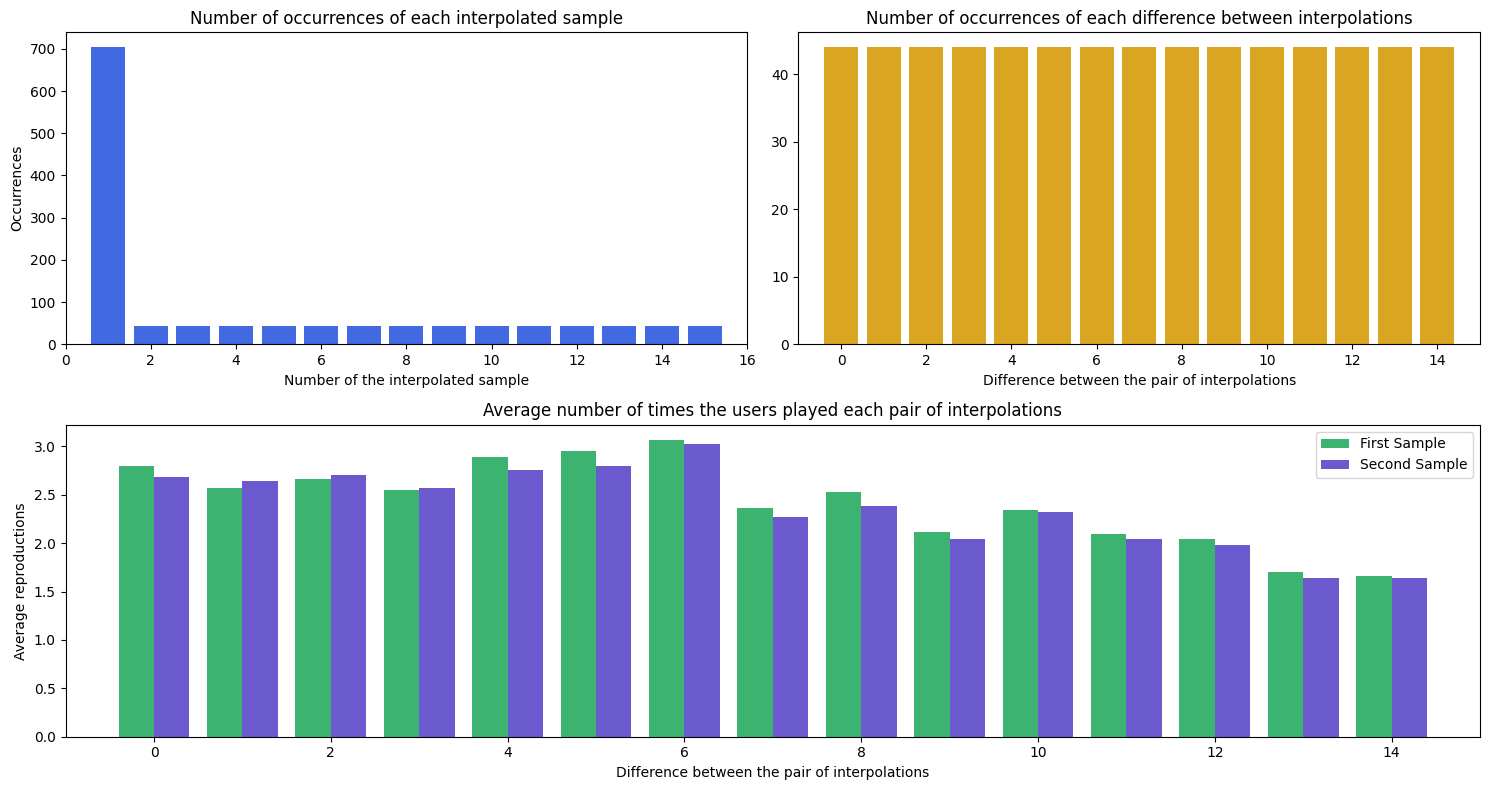

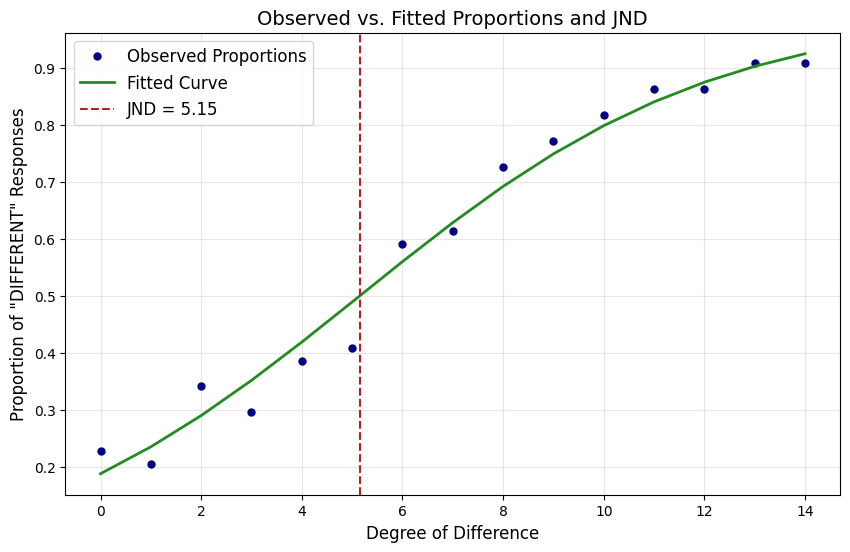

In [8]:
# Get the responses of the experiment from the json files
audio_comparisons = []
for file_name in os.listdir('./'):
    if file_name.endswith('.json'):
        file_path = os.path.join('./', file_name)
        audio_comparisons.extend(read_data_from_file(file_path))
interpolation_frequencies, range_frequencies, average_range_play_frequencies_1, average_range_play_frequencies_2, different_responses_proportion = extract_audio_comparisons_data(audio_comparisons)

# Plot frequency histograms
plot_frequency_histograms(interpolation_frequencies, range_frequencies, average_range_play_frequencies_1, average_range_play_frequencies_2)

compute_jnd(different_responses_proportion)

Processing data for headphone type: over-ear


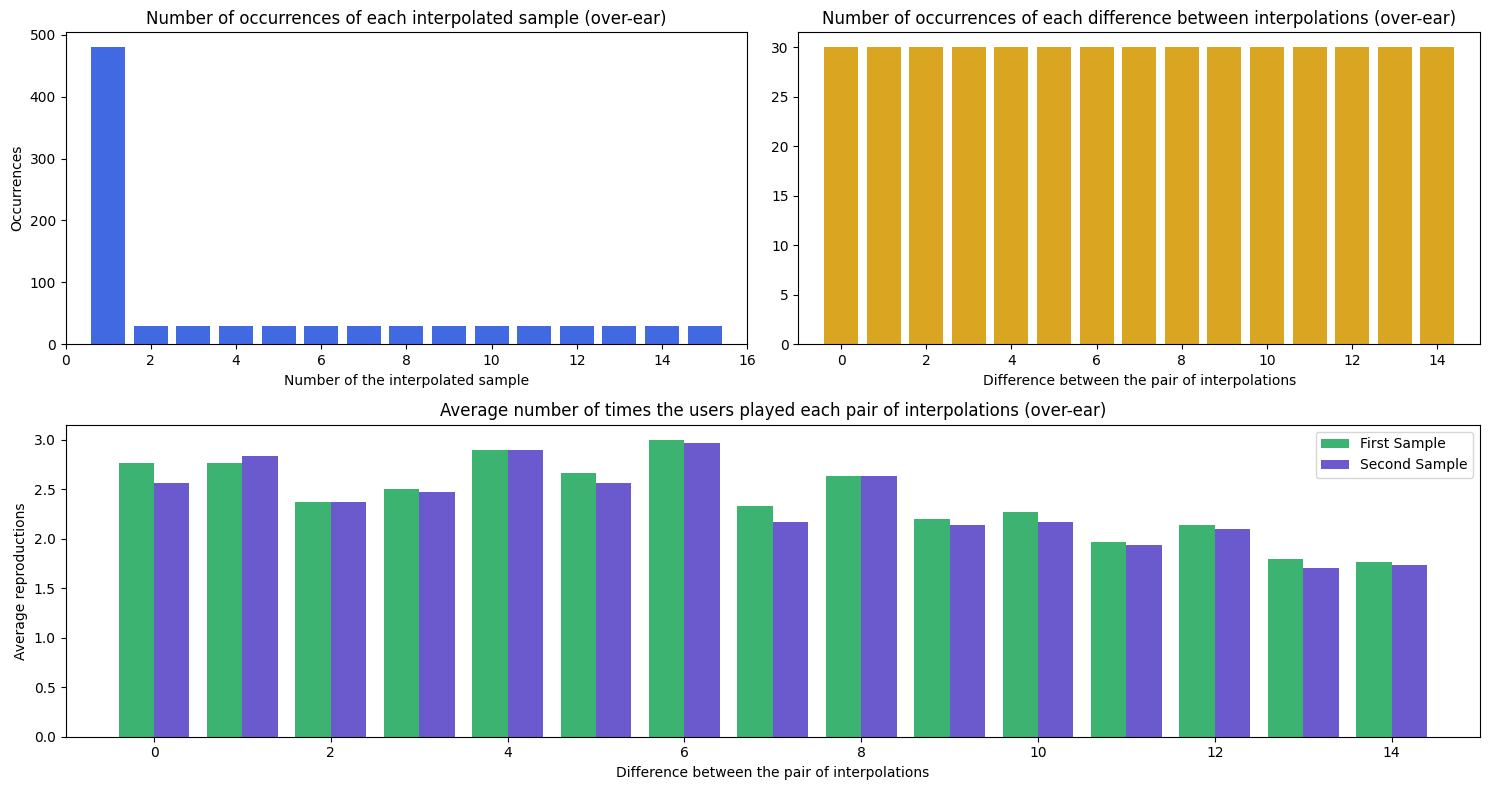

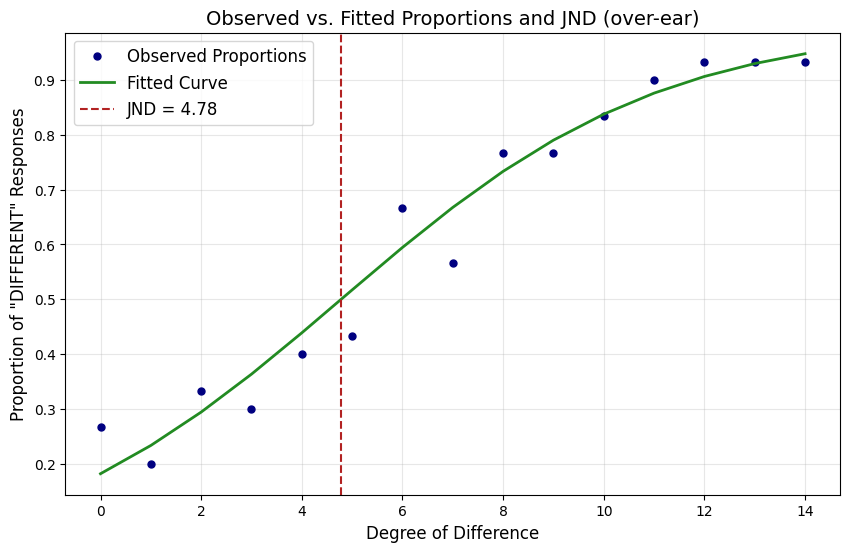

Processing data for headphone type: in-ear


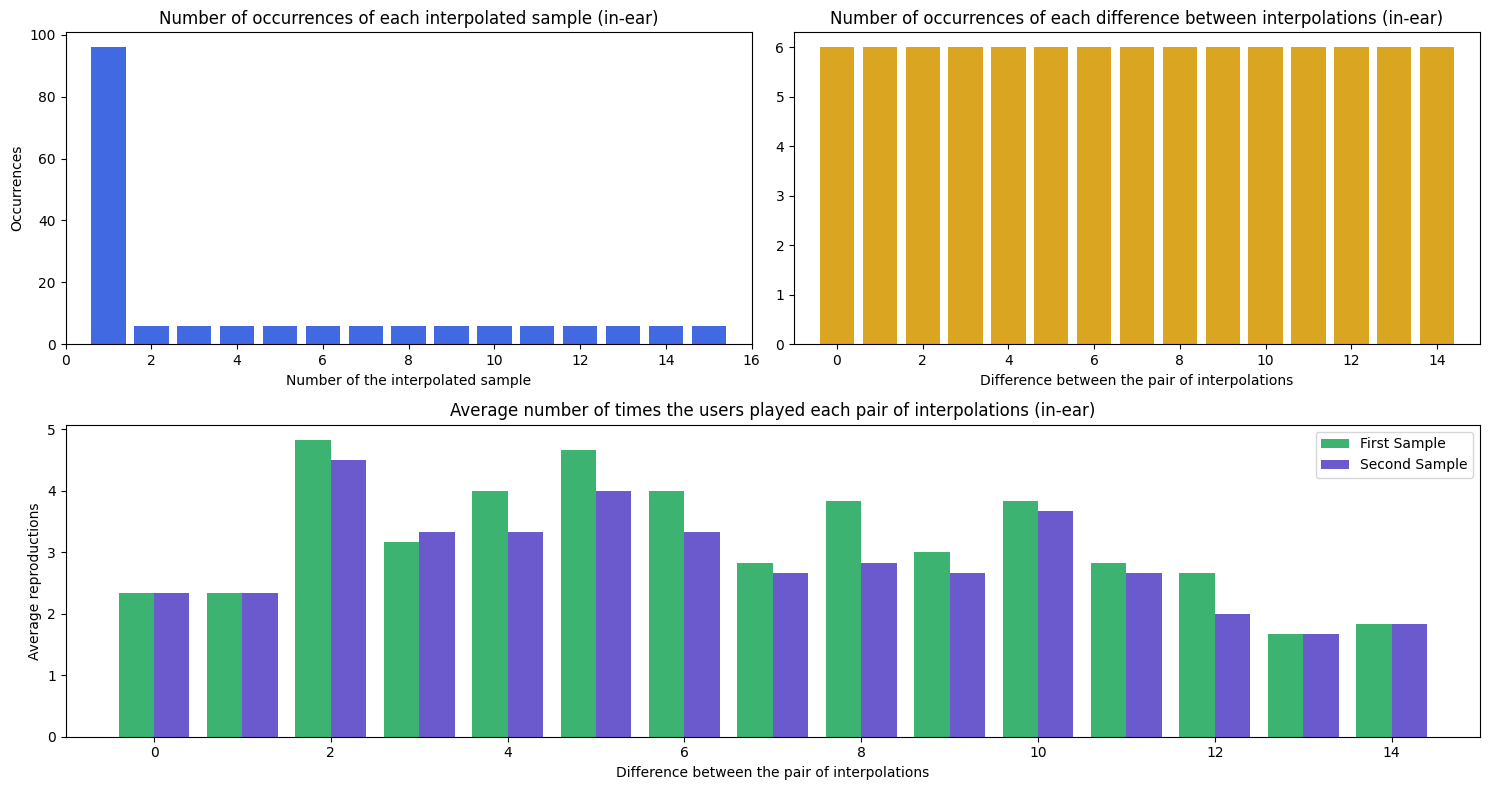

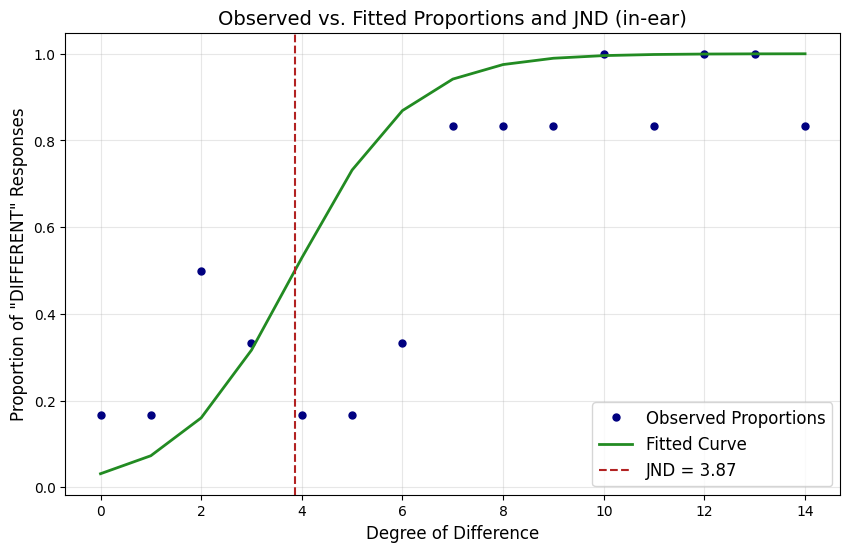

Processing data for headphone type: none


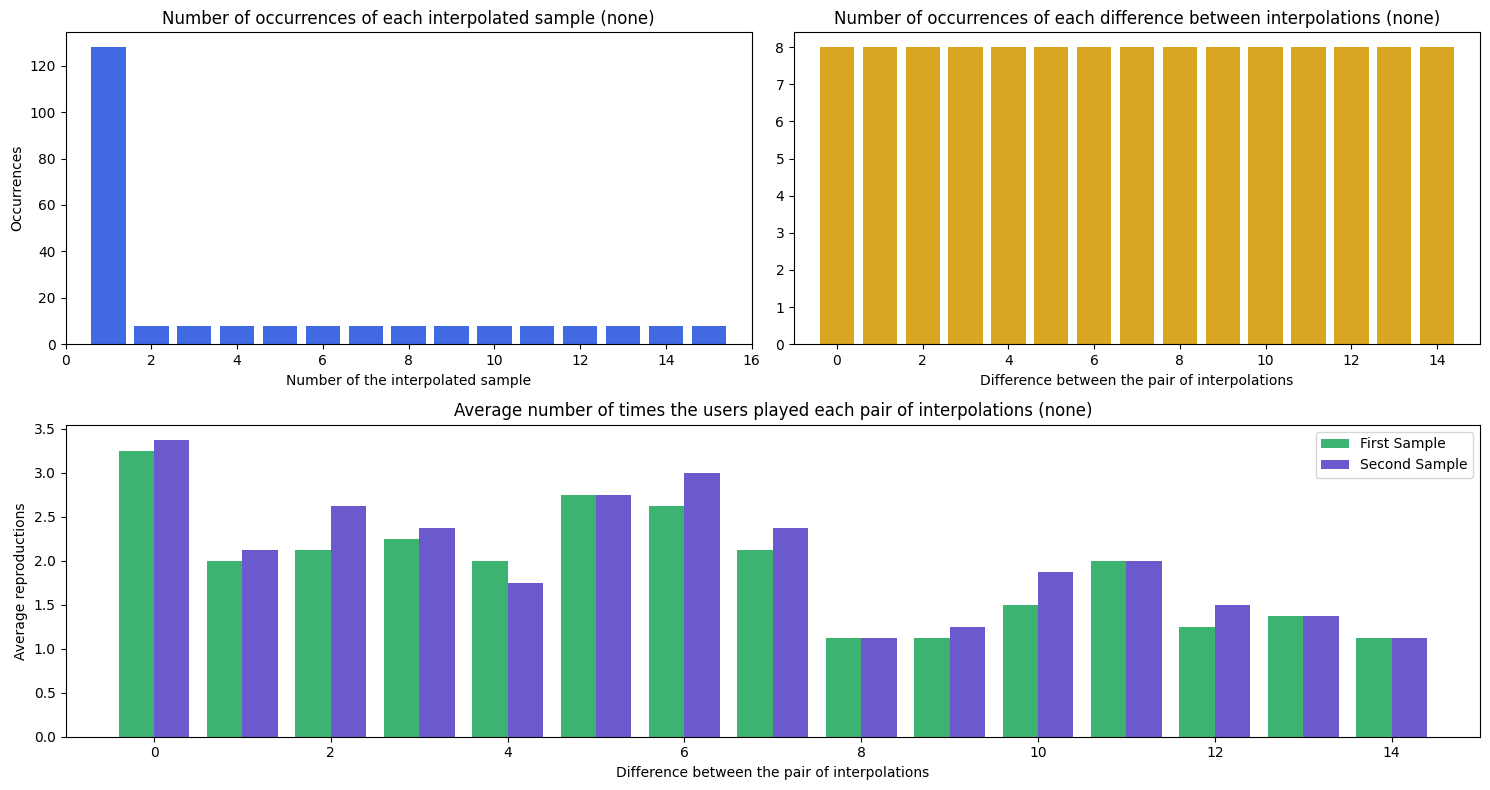

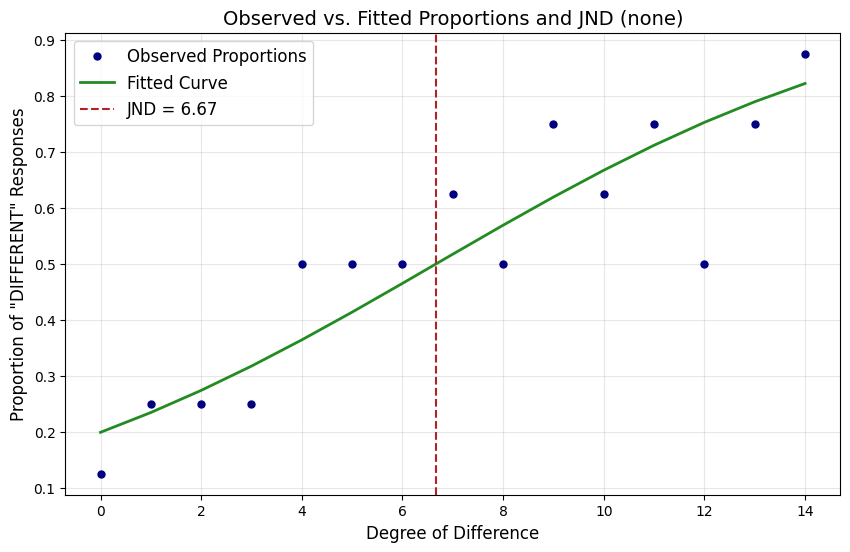

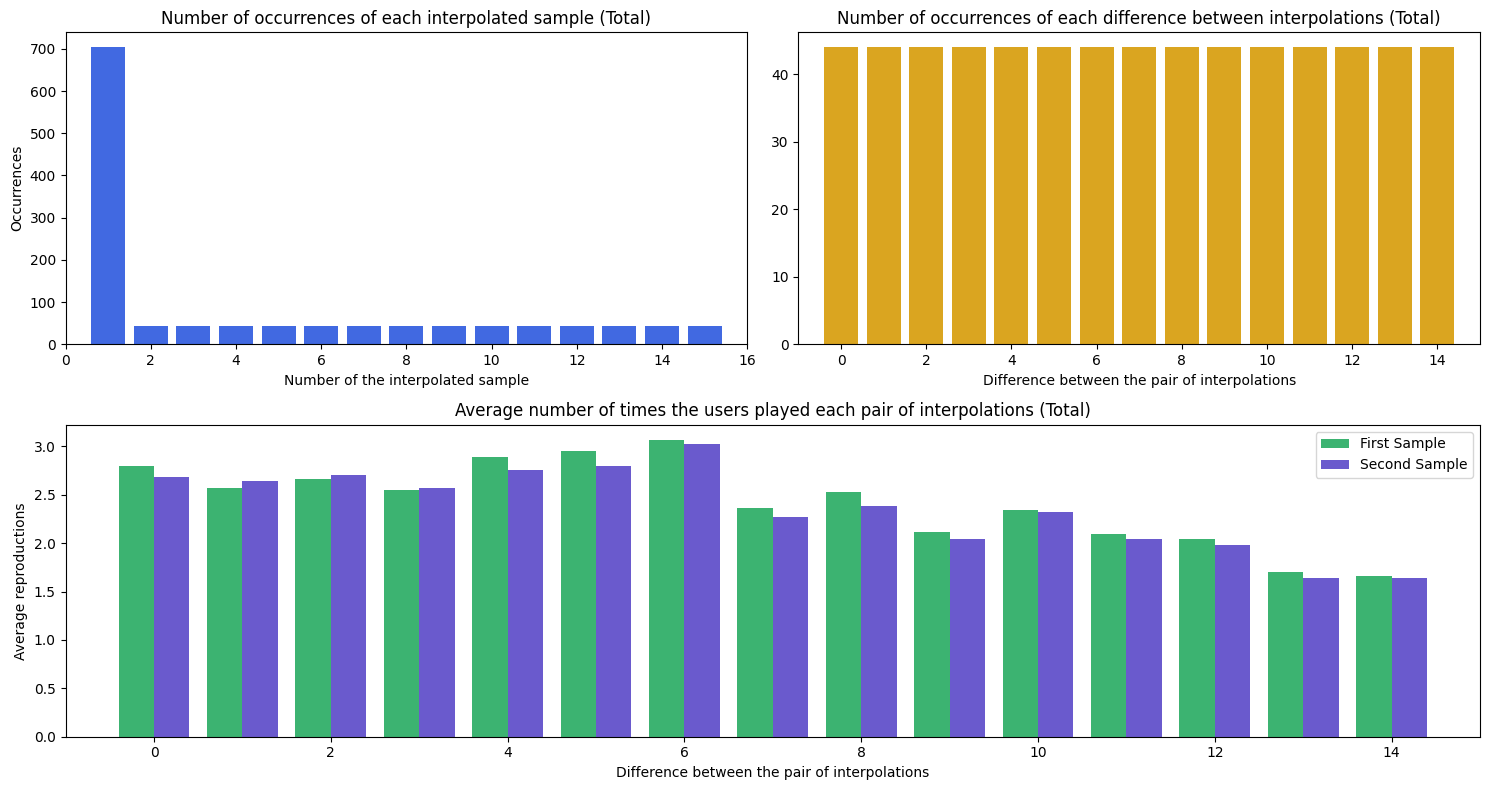

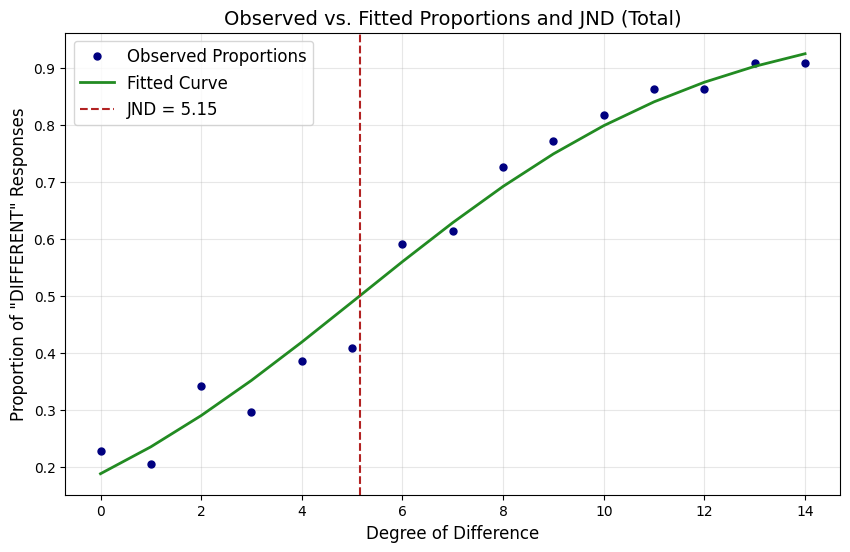

In [9]:
### PLOTS BY HEADPHONE TYPE

def read_data_from_file(file_path):
    # Read raw file content
    with open(file_path, 'r') as file:
        content = file.read()

    # Replace MongoDB-specific data types with JSON-compatible ones
    content = re.sub(r'ObjectId\("([^"]+)"\)', r'{"$oid": "\1"}', content)
    content = re.sub(r'ISODate\("([^"]+)"\)', r'{"$date": "\1"}', content)
    content = re.sub(r'NumberInt\((\d+)\)', r'\1', content)

    # Parse JSON using bson.json_util
    data = json_util.loads(content)

    # Return audio comparisons and headphone type from data
    return data['audioComparisons'], data['headphoneType']

def split_data_by_headphone_type(audio_comparisons_with_types):
    # Initialize dictionaries to store data for each headphone type
    data_by_type = {
        'over-ear': [],
        'in-ear': [],
        'none': []
    }

    # Split the data based on headphoneType
    for comparisons, headphone_type in audio_comparisons_with_types:
        for comparison in comparisons:
            comparison['headphoneType'] = headphone_type  # Add headphoneType to each comparison
        data_by_type[headphone_type].extend(comparisons)

    return data_by_type

def compute_jnd(different_responses_proportion, headphone_type):
    # Precomputed vector qi (proportion of "DIFFERENT" responses for each degree of difference)
    qi = different_responses_proportion

    # Avoid issues with qi = 0 or qi = 1 by clamping
    epsilon = 1e-6
    qi = np.clip(qi, epsilon, 1 - epsilon)

    # Logistic transformation
    li = np.log((1 - qi) / qi)

    # Degrees of difference
    i = np.arange(len(qi))

    # Perform linear regression
    slope, intercept, _, _, _ = linregress(i, li)

    # Calculate JND
    jnd = np.abs(intercept/slope)

    # Generate the regression line values
    li_predicted = slope * i + intercept

    # Detransform the regression line back to proportions
    qr = 1 / (1 + np.exp(li_predicted))

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(i, qi, 'o', label='Observed Proportions', markersize=5, color='navy')
    plt.plot(i, qr, '-', label='Fitted Curve', linewidth=2, color='forestgreen')
    plt.axvline(jnd, linestyle='--', label=f'JND = {jnd:.2f}', color='firebrick')
    plt.xlabel('Degree of Difference', fontsize=12)
    plt.ylabel('Proportion of "DIFFERENT" Responses', fontsize=12)
    plt.title(f'Observed vs. Fitted Proportions and JND ({headphone_type})', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

def plot_frequency_histograms(interpolation_frequencies, range_frequencies, average_range_play_frequencies_1, average_range_play_frequencies_2, headphone_type):
    # Create figure and gridspec
    plt.figure(figsize=(15, 8))
    gs = plt.GridSpec(2, 2)

    # Plot 1: Interpolation frequencies histogram
    ax1 = plt.subplot(gs[0, 0])  # First row, first column
    ax1.bar(range(1, 16), interpolation_frequencies, color='royalblue')
    ax1.set_title(f"Number of occurrences of each interpolated sample ({headphone_type})")
    ax1.set_xlabel("Number of the interpolated sample")
    ax1.set_ylabel("Occurrences")
    ax1.set_xlim(0, 16)

    # Plot 2: Range frequencies histogram
    ax2 = plt.subplot(gs[0, 1])  # First row, second column
    ax2.bar(range(0, 15), range_frequencies, color='goldenrod')
    ax2.set_title(f"Number of occurrences of each difference between interpolations ({headphone_type})")
    ax2.set_xlabel("Difference between the pair of interpolations")
    ax2.set_xlim(-1, 15)

    # Plot 3: Multi-bar chart for range frequencies
    ax3 = plt.subplot(gs[1, :])  # Second row, spanning both columns
    ax3.bar(np.arange(len(average_range_play_frequencies_1)) - 0.2, average_range_play_frequencies_1, 0.4, color='mediumseagreen', label='First Sample')
    ax3.bar(np.arange(len(average_range_play_frequencies_1)) + 0.2, average_range_play_frequencies_2, 0.4, color='slateblue', label='Second Sample')
    ax3.set_title(f"Average number of times the users played each pair of interpolations ({headphone_type})")
    ax3.set_xlabel("Difference between the pair of interpolations")
    ax3.set_ylabel("Average reproductions")
    ax3.set_xlim(-1, 15)
    ax3.legend()

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()

def process_and_plot_total_data(audio_comparisons_with_types):
    # Combine all data across headphone types
    total_comparisons = []
    for comparisons, _ in audio_comparisons_with_types:
        total_comparisons.extend(comparisons)

    # Extract data for the total dataset
    interpolation_frequencies, range_frequencies, average_range_play_frequencies_1, average_range_play_frequencies_2, different_responses_proportion = extract_audio_comparisons_data(total_comparisons)

    # Plot frequency histograms for the total dataset
    plot_frequency_histograms(interpolation_frequencies, range_frequencies, average_range_play_frequencies_1, average_range_play_frequencies_2, "Total")

    # Compute and plot JND for the total dataset
    compute_jnd(different_responses_proportion, "Total")

def process_and_plot_by_headphone_type(audio_comparisons_with_types):
    # Split data by headphone type
    data_by_type = split_data_by_headphone_type(audio_comparisons_with_types)

    # Process and plot for each headphone type
    for headphone_type, comparisons in data_by_type.items():
        print(f"Processing data for headphone type: {headphone_type}")

        # Extract data
        interpolation_frequencies, range_frequencies, average_range_play_frequencies_1, average_range_play_frequencies_2, different_responses_proportion = extract_audio_comparisons_data(comparisons)

        # Plot frequency histograms
        plot_frequency_histograms(interpolation_frequencies, range_frequencies, average_range_play_frequencies_1, average_range_play_frequencies_2, headphone_type)

        # Compute and plot JND
        compute_jnd(different_responses_proportion, headphone_type)

# Get the responses of the experiment from the json files
audio_comparisons_with_types = []
for file_name in os.listdir('./'):
    if file_name.endswith('.json'):
        file_path = os.path.join('./', file_name)
        comparisons, headphone_type = read_data_from_file(file_path)
        audio_comparisons_with_types.append((comparisons, headphone_type))

# Process and plot data for each headphone type
process_and_plot_by_headphone_type(audio_comparisons_with_types)

# Process and plot data for the total dataset
process_and_plot_total_data(audio_comparisons_with_types)